# Carregar as bibliotecas

In [1]:
import numpy as np
from skimage import io, data, filters, util, color, transform, exposure, measure, feature
from skimage.util import img_as_float, img_as_uint, img_as_ubyte
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
np.seterr(divide='ignore', invalid='ignore')

import pandas as pd

import matplotlib.pyplot as plt

### Base MNIST

In [6]:
# download do treino
!gdown 1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb

Downloading...
From (original): https://drive.google.com/uc?id=1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb
From (redirected): https://drive.google.com/uc?id=1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb&confirm=t&uuid=5b83048a-26e1-4a77-8993-8ff19ecf265d
To: /content/mnist_train.csv
100% 110M/110M [00:00<00:00, 117MB/s] 


In [7]:
# download do teste
!gdown 1v8m7yCg0GrJBzWs2MVUPs_Ywe3dTvbCx

Downloading...
From: https://drive.google.com/uc?id=1v8m7yCg0GrJBzWs2MVUPs_Ywe3dTvbCx
To: /content/mnist_test.csv
100% 18.3M/18.3M [00:00<00:00, 73.5MB/s]


## Carregar os arquivos com o conjunto de treino e teste

In [8]:
data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')

In [63]:
# imagens
x_train = data_train.iloc[:,1:].to_numpy()
# etiquetas
y_train = data_train.iloc[:,0].to_numpy()

# imagen
x_test = data_test.iloc[:,1:].to_numpy()
# etiquetas
y_test = data_test.iloc[:,0].to_numpy()

In [64]:
def feature_extraction(dataset):
  hog_features = []
  for image in dataset:
    # redimensionar a imagem para 28x28 pixels
    image_reshaped = image.reshape(28,28)
    # extrair as características HOG
    fd = feature.hog(image_reshaped, orientations=9, pixels_per_cell=(8, 8),  cells_per_block=(2, 2))
    hog_features.append(fd)
  return np.array(hog_features)

## Extração de características

In [65]:
hog_X_train = feature_extraction(x_train)
hog_X_test = feature_extraction(x_test)

## Normalização minmax

<p>Utilizar o método de mínimos e máximos para normalizar os dados</p>

In [66]:
# normalização
std_scaler = preprocessing.MinMaxScaler().fit(hog_X_train)
hog_Xn_train = std_scaler.transform(hog_X_train)
hog_Xn_test = std_scaler.transform(hog_X_test)
# incluir codigo

In [67]:
# Passo 1, importar biblioteca
from sklearn.neural_network import MLPClassifier

# Passo 2, instanciar o classificador com duas camdas ocultas de 128 e 32 neuronios
clf = MLPClassifier(hidden_layer_sizes=(256,32),activation="relu",random_state=1)

# 3.3 Treinar
clf.fit(hog_Xn_train, y_train)



MLPClassifier(hidden_layer_sizes=(256, 32), random_state=1)

In [68]:
def matriz_confusao(y_test, y_pred, labels):
  matriz = metrics.confusion_matrix(y_test, y_pred)
  tot = np.sum(matriz, axis=1, keepdims=True)
  np.set_printoptions(precision=2)
  m_porc = matriz/tot
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=labels)
  disp.plot(values_format='.2f')
  plt.show()


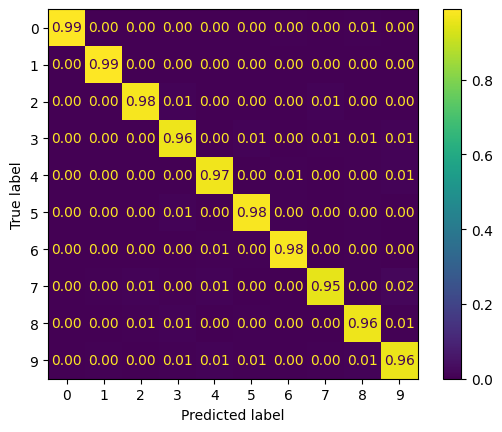

In [70]:
# Passo 4, avaliar o modelo
# incluir codigo
y_pred = clf.predict(hog_Xn_test)
matriz_confusao(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9])

## Pytorch

## Importar bibliotecas

In [71]:
import torch
from torch import nn
import torch.nn.functional as F

## Transformar tensores numpy em tensores Pytorch

In [72]:
X_train = torch.tensor(hog_Xn_train, dtype=torch.float32)
X_test = torch.tensor(hog_Xn_test, dtype=torch.float32)
Y_train = torch.tensor(y_train, dtype=torch.long)
Y_test = torch.tensor(y_test, dtype=torch.long)


## Definição da rede neural em Pytorch

In [73]:
def make_layers(cfg, in_channels = 3):
    layers = []
    for v in cfg:
        layers += [nn.Linear(in_channels, v), nn.ReLU()]
        in_channels = v
    return nn.Sequential(*layers)

In [74]:
class ModeloSkLearn(nn.Module):
    def __init__(self,entrada=4,camadas_escondidas=256 ,saida=3):
        super().__init__()
        self.hidden_layers_num = camadas_escondidas
        self.dense_hidden = make_layers(self.hidden_layers_num, entrada)
        self.fc = nn.Linear(self.hidden_layers_num[-1], saida)

    def forward(self, x):
        x = self.dense_hidden(x)
        x = self.fc(x)
        return x

## Função de treino

In [75]:
def meu_fit(modelo, funcao_objetivo, otimizador, data, labels, epocas = 100):
    custos = []
    for i in range(epocas):
        # zerar os gradientes
        otimizador.zero_grad()

        # forward pass
        y_predito = modelo(data)
        # cálculo do loss (erro)
        custo = funcao_objetivo(y_predito, labels)

        # backward pass, correção de pesos
        custo.backward()
        otimizador.step()

    custos.append(custo.item())
    return custos

## Função de predição

In [76]:
def meu_predict(modelo, data):
    preds = []
    # deshabilitar atualização de pesos, rede em modo avaliação
    with torch.no_grad():
        for val in data:
            y_predito = modelo.forward(val)
            preds.append(y_predito.argmax().item())
    return preds

In [77]:
def meu_predict2(modelo, data):
    preds = np.empty((0), int)
    # deshabilitar atualização de pesos, rede em modo avaliação
    with torch.no_grad():
       outputs = modelo.forward(data)
       _, predictions = torch.max(outputs, 1)
       preds = np.append(preds, predictions)

    return preds

In [78]:
print(X_train.shape)
print(Y_train.shape)

torch.Size([60000, 144])
torch.Size([60000])


## Inicio de treinamento

In [79]:
# instanciaçao do modelo, definir 128 e 32 neuronios nas camadas ocultas
modelo2 = ModeloSkLearn(entrada=144, camadas_escondidas=[128, 32] , saida=10 )

# definir funções de otimização e de perda (custo)
otimizador = torch.optim.Adam(modelo2.parameters(), lr=0.01)
funcao_objetivo = nn.CrossEntropyLoss()

# treinar o modelo
meu_fit(modelo2, funcao_objetivo, otimizador, X_train, Y_train)

[0.13036777079105377]

## Avaliar desempenho do modelo

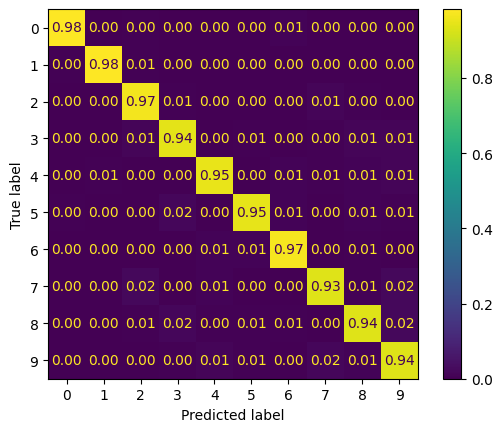

In [80]:
# avaliar o modelo
y_pred = meu_predict(modelo2, X_test)

# gerar matriz de confusão
matriz_confusao(Y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9])

# Pytorch
## Carregar base MNIST para classificar usando Rede Neural

In [81]:
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
from torchvision import datasets

In [82]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17571438.88it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 477461.07it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4268902.75it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11346354.24it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [83]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform = transforms.ToTensor(),
    download=True
)

## Datalaloader usada para criar batches durante o treino

In [84]:
# Data loader
# Util pq cria automáticamente batches durante o treino
# além de embaralhar os dados
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False)

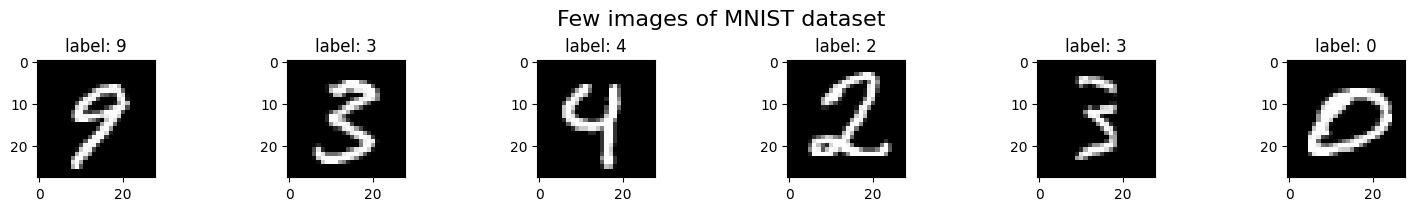

In [85]:
# verificação do funcionamento do dataloader
nb_digits_to_display = 6
f, ax = plt.subplots(1,nb_digits_to_display, figsize=(15,2), constrained_layout=True)
f.suptitle("Few images of MNIST dataset", fontsize=16)
for x, y in train_loader:
  for i in range(nb_digits_to_display):
    ax[i].imshow(x[i].numpy()[-1,:,:], cmap = 'gray')
    ax[i].set_title(f"label: {y[i].numpy()}")
  break

# Usar a rede definada previamente com a base do Pytorch
## Função de treinamento

In [86]:
def meu_batch_fit(modelo, funcao_objetivo, otimizador, train_loader, epocas = 10):
    custos = []
    losses = np.zeros(epocas)
    for i in range(epocas):
      train_loss = []
      for x, y in train_loader:
        # zerar os gradientes
        otimizador.zero_grad()

        # reshape the input
        x = x.view(-1,784)

        # forward pass
        y_predito = modelo(x)
        custo = funcao_objetivo(y_predito, y)

        # backward pass
        custo.backward()
        otimizador.step()

        train_loss.append( custo.item() )
      losses[i] = np.mean(train_loss)
      print(f'Epoch {i+1}/{epocas}, Train loss: {losses[i]:.4}')

    return losses

## Função de validação / teste

In [87]:
def meu_batch_predict(modelo, test_loader):
    preds = np.array([])
    true_label = np.array([])
    with torch.no_grad():
        for x, y in test_loader:
            # reshape the input
            x = x.view(-1,784)
            outputs = modelo(x)
            # get prediction
            _, y_predito = torch.max(outputs, 1)
            preds = np.concatenate( (preds, y_predito.cpu().numpy()) )
            true_label = np.concatenate( (true_label, y.cpu().numpy()) )
    return preds, true_label

## Instanciação da rede e treinamento

In [88]:
modelo3 = ModeloSkLearn(entrada=784, camadas_escondidas=[128, 32] , saida=10 )

#

# Funções de otimização e de custo
otimizador = torch.optim.Adam(modelo3.parameters(), lr=0.01)
funcao_objetivo = nn.CrossEntropyLoss()
# incluir codigo

# treinar o modelo
train_loss = meu_batch_fit(modelo3, funcao_objetivo, otimizador, train_loader)

Epoch 1/10, Train loss: 0.2563
Epoch 2/10, Train loss: 0.1216
Epoch 3/10, Train loss: 0.09455
Epoch 4/10, Train loss: 0.0791
Epoch 5/10, Train loss: 0.07363
Epoch 6/10, Train loss: 0.06839
Epoch 7/10, Train loss: 0.0585
Epoch 8/10, Train loss: 0.05776
Epoch 9/10, Train loss: 0.05554
Epoch 10/10, Train loss: 0.05396


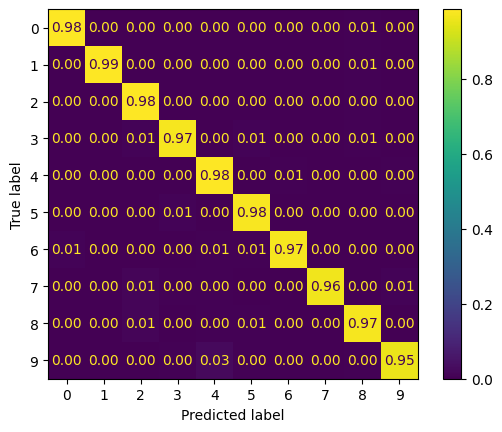

In [89]:
# avaliar o modelo
y_pred, Y_test = meu_batch_predict(modelo3, test_loader)

# gerar matriz de confusão
matriz_confusao(Y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9])


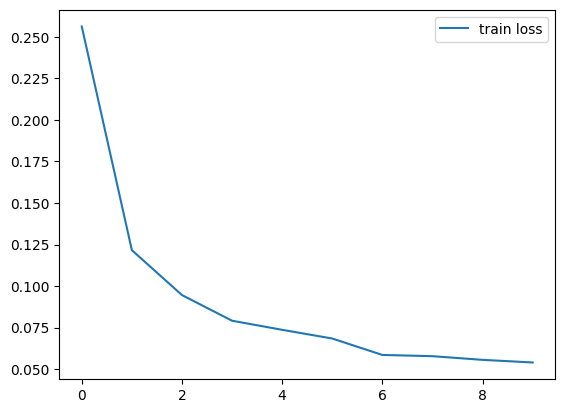

In [90]:
plt.plot(train_loss, label = 'train loss')
plt.legend()
plt.show()